In [38]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import QuantileTransformer
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [39]:
# load data
df = pd.read_csv("Financial data final.csv")
df.set_index('Symbol',inplace = True)
spy = pd.read_csv("spy.csv")
spy.set_index('Symbol',inplace = True)
price = pd.read_csv("monthly price.csv")
price.set_index('Symbol',inplace = True)
tb=pd.read_csv('US T-bill 3 month.csv')
tb.set_index('Symbol',inplace = True)
c_list=pd.read_csv('company list.csv')
c_list.set_index('Company name',inplace = True)
senti=pd.read_csv('sentiments.csv')
senti.set_index('Company name',inplace = True)

In [40]:
# join with sentiment results
senti_c = c_list.join(senti)
print(c_list)
print(senti_c)
print(senti)
senti_c.set_index('Symbol',inplace = True)
df=df.join(senti_c)

                     Symbol
Company name               
Agilent Technologies      A
Apple                  AAPL
AmerisourceBergen       ABC
Abbott                  ABT
Adobe                  ADBE
...                     ...
Xcel Energy             XEL
ExxonMobil              XOM
Yum! Brands             YUM
Zimmer Biomet           ZBH
Zions Bancorp          ZION

[241 rows x 1 columns]
                     Symbol  Num_Positive
Company name                             
Agilent Technologies      A     30.000000
Apple                  AAPL     48.000000
AmerisourceBergen       ABC     41.000000
Abbott                  ABT     51.000000
Adobe                  ADBE     40.350877
...                     ...           ...
Xcel Energy             XEL     31.111111
ExxonMobil              XOM     38.000000
Yum! Brands             YUM     45.000000
Zimmer Biomet           ZBH     25.000000
Zions Bancorp          ZION     34.000000

[241 rows x 2 columns]
               Num_Positive
Company name  

In [41]:
# scaling the data
scaler = QuantileTransformer(output_distribution='normal', random_state=0)
scaled_values = scaler.fit_transform(df) 
df.loc[:,:] = scaled_values

C:\Users\matts\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (241). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "


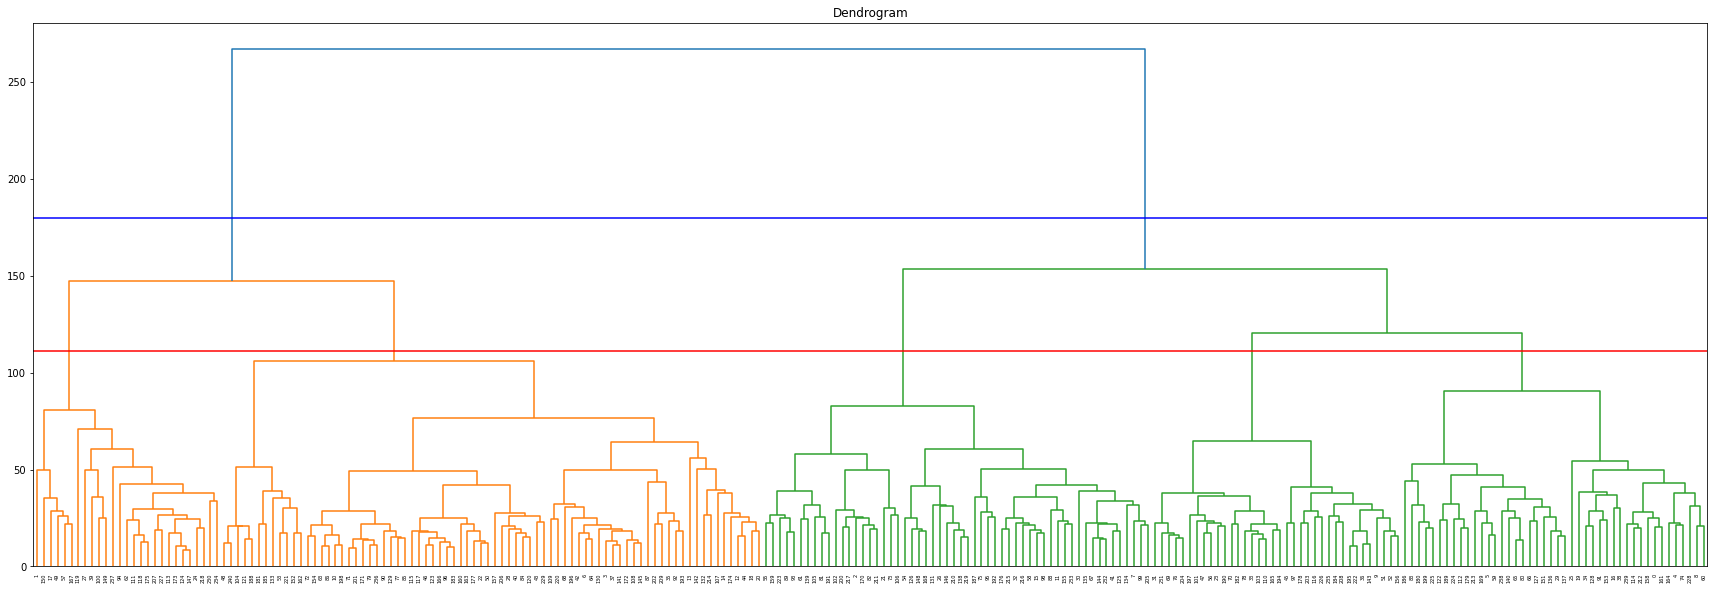

In [42]:
# plot the dendrogram
plt.figure(figsize=(30,10))
dendrogram1 = dendrogram(linkage(df, method = 'ward')) # finding the optimal number of clusters using dendrogram
plt.title('Dendrogram') # title of the dendrogram
plt.axhline(y=111, color='r', linestyle='-')
plt.axhline(y=180, color='b', linestyle='-')
plt.show() # show the dendrogram

In [44]:
print(spy)
spy["1/31/2006"].values

        1/31/2006  2/28/2006  3/31/2006  4/28/2006  5/31/2006  6/30/2006  \
Symbol                                                                     
SPY     92.759399  93.290512  94.454559  96.028061  93.135605  92.967575   

        7/31/2006  8/31/2006  9/29/2006  10/31/2006  ...   3/31/2020  \
Symbol                                               ...               
SPY     93.796692  95.843544  98.000488   101.53373  ...  248.923096   

         4/30/2020   5/29/2020   6/30/2020   7/31/2020   8/31/2020  \
Symbol                                                               
SPY     282.181854  295.626495  299.551025  318.588074  340.824463   

         9/30/2020  10/30/2020  11/30/2020  12/31/2020  
Symbol                                                  
SPY     326.754791  319.882996  354.678894  366.257874  

[1 rows x 180 columns]


array([92.759399])

In [45]:
# compute prices for bench marks
# for ETF: spy
share_spy = 100000/spy["1/31/2006"].values # how many spy shares
spy.insert(0,"number of shares",share_spy) 
spy = spy.mul(spy["number of shares"], axis="index")
# for all 241 companies
alldf = price.copy()                        
share_all = 100000/alldf["1/31/2006"].values
alldf.insert(0,"number of shares",share_all)
alldf = alldf.mul(alldf["number of shares"], axis="index")
# copy df columns for the next loop
dfcol = df.columns

total return for 5 clusters: [3.93907102 7.25479656 4.54616049 5.53485828 5.15290105]
max is 7.2547965588975325 max is at label 1
Index(['A', 'ADBE', 'ADI', 'ADSK', 'AMD', 'AMZN', 'AZO', 'BBWI', 'BIIB', 'BSX',
       'CTAS', 'CTXS', 'DGX', 'DHI', 'EA', 'EMN', 'EQR', 'FISV', 'IFF', 'INTU',
       'KLAC', 'LEN', 'LH', 'MAR', 'MAS', 'MCO', 'MSI', 'MU', 'NLOK', 'NTAP',
       'NVDA', 'PAYX', 'PKI', 'PLD', 'PSA', 'RHI', 'SPG', 'TPR', 'TROW', 'VMC',
       'VNO', 'WAT', 'YUM', 'ZBH'],
      dtype='object', name='Symbol') (array([0, 1, 2, 3, 4], dtype=int64), array([78, 44, 56, 27, 36], dtype=int64))


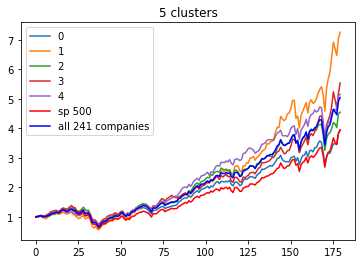

In [16]:
# validate the performance
for n in [5]:
    df_l = df.copy(deep=True)
    h_cl_l = AgglomerativeClustering(linkage="ward",n_clusters = n).fit(df_l)
    df_l["label"] = h_cl_l.labels_
    p_l = df_l.join(price)
    p_l.drop(dfcol, axis=1, inplace=True)
    price_list = []
    total_return = np.array([])
    for x in range(n):
        edf = p_l[p_l["label"] == x]
        share = 100000/edf["1/31/2006"].values
        edf.insert(1,"number of shares",share)
        edf = edf.mul(edf["number of shares"], axis="index")
        p_l_x = edf.describe().iloc[1].values[2:]
        price_list.append(p_l_x)
        price_list[x] = [z/100000 for z in price_list[x]]
        plt.plot(price_list[x],label = "{}".format(x))
        total_return = np.append(total_return,price_list[x][-1])
    print("total return for {} clusters:".format(n),total_return)
    print("max is {}".format(total_return.max()),"max is at label {}".format(total_return.argmax()) )
    print(df_l[df_l["label"] == total_return.argmax()].index,np.unique(h_cl_l.labels_, return_counts=True))
    plt.plot(spy.iloc[0].values[1:]/100000,label = "sp 500",color = 'r')
    plt.plot(alldf.describe().iloc[1].values[1:]/100000,label = "all 241 companies", color = 'b')
    plt.title("{} clusters".format(n))
    plt.rc('xtick', labelsize=10) 
    plt.rc('legend',fontsize=10)
    plt.legend()
    plt.show()

In [53]:
p_l

,label,1/31/2006,2/28/2006,3/31/2006,4/28/2006,5/31/2006,6/30/2006,7/31/2006,8/31/2006,9/29/2006,...,3/31/2020,4/30/2020,5/29/2020,6/30/2020,7/31/2020,8/31/2020,9/30/2020,10/30/2020,11/30/2020,12/31/2020
Symbol,,,,,,,,,,,,,,,,,,,,,
A,1,22.3443,23.7215,24.7428,25.3161,22.9901,20.7959,18.7400,21.1912,21.5404,...,70.8474,75.8331,87.1893,87.5970,95.4874,99.5416,100.0571,101.3737,116.0798,117.6586
AAPL,3,2.3089,2.0942,1.9178,2.1523,1.8276,1.7512,2.0780,2.0747,2.3539,...,62.7120,72.4558,78.6164,90.2034,105.0988,127.8654,114.7558,107.8691,118.1701,131.7092
ABC,2,17.0990,18.0301,18.9239,16.9167,17.0990,16.4439,16.8675,17.3325,17.7407,...,85.7499,86.8738,92.8298,98.1168,97.5521,94.8577,94.7502,93.9192,101.2118,95.9603
ABT,0,14.2252,14.5648,14.0011,14.1382,14.1249,14.4260,15.9078,16.2175,16.1708,...,76.5621,89.7108,92.4677,89.0679,98.4122,107.0467,106.4209,103.1266,106.1779,107.4240
ADBE,1,39.7300,38.5500,34.9500,39.2000,28.6300,30.3600,28.5100,32.4400,37.4600,...,318.2400,353.6400,386.6000,435.3100,444.3200,513.3900,490.4300,447.1000,478.4700,500.1200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XEL,0,10.5735,10.1053,9.9994,10.3795,10.3410,10.6925,11.1719,11.5956,11.6360,...,57.1182,60.2062,61.5986,59.6020,65.8388,66.2536,66.2171,67.1959,64.6339,64.3961
XOM,3,36.1731,34.4060,35.2695,36.5560,35.4753,35.7316,39.4533,39.5944,39.2609,...,33.2225,40.6597,40.5692,39.9001,37.5446,36.3384,31.2343,29.6785,35.5105,38.3882
YUM,1,13.0129,12.5474,12.8525,13.6271,13.2895,13.2553,11.9022,12.9284,13.7669,...,66.1322,83.4059,87.0384,84.3030,88.3189,93.4278,88.9928,90.9715,103.5785,106.2806


In [17]:
ha_cl1 = AgglomerativeClustering(linkage="ward",n_clusters = 5).fit(df)
np.unique(ha_cl1.labels_, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64), array([78, 44, 56, 27, 36], dtype=int64))

In [18]:
df_a = df.copy(deep=True)
df_a["label"] = ha_cl1.labels_
p_a = df_a.join(price)
p_a.drop(dfcol, axis=1, inplace=True)

## analysis

In [19]:
# test1 = p_a.loc[['VTRS','ADSK','CSCO']]
test1 = p_a[p_a["label"] == 1]
share_t = 100000/test1["1/31/2006"].values
test1.insert(1,"number of shares",share_t)
test1 = test1.mul(test1["number of shares"], axis="index")
p_l_t = test1.describe().iloc[1].values[2:]/100000

In [20]:
# price df of desired cluster, spy, all
p_t = pd.DataFrame([p_l_t,spy.iloc[0][1:]/100000,alldf.describe().iloc[1].values[1:]/100000])

In [21]:
# percent change in price df
p_t_n = p_t.pct_change(axis='columns').dropna(1)

In [22]:
# CAGR
cagr_t = (p_l_t[-1]/p_l_t[0])**(1/15)-1
cagr_spy = (spy.iloc[0][1:][-1]/spy.iloc[0][1:][0])**(1/15)-1
cagr_all = (alldf.describe().iloc[1].values[1:][-1]/alldf.describe().iloc[1].values[1:][0])**(1/15)-1
# total return
tr_spy = spy.iloc[0].values[1:][-1]/100000
tr_all = alldf.describe().iloc[1].values[1:][-1]/100000
tr_t = p_l_t[-1]

In [23]:
# market correlation
from scipy.stats import pearsonr
corr_t, _ = pearsonr(p_t_n.transpose()[0], p_t_n.transpose()[1])
corr_spy, _ = pearsonr(p_t_n.transpose()[1], p_t_n.transpose()[1])
corr_all, _ = pearsonr(p_t_n.transpose()[2], p_t_n.transpose()[1])

In [24]:
# sharpe ratio
sr_t = (p_t_n.transpose().describe()[0][1]-0.0009)/p_t_n.transpose().describe()[0][2]*(12**0.5)
sr_spy = (p_t_n.transpose().describe()[1][1]-0.0009)/p_t_n.transpose().describe()[1][2]*(12**0.5)
sr_all = (p_t_n.transpose().describe()[2][1]-0.0009)/p_t_n.transpose().describe()[2][2]*(12**0.5)

In [25]:
# standard deviation
std_t = p_t_n.transpose().describe()[0][2]*(12**0.5)
std_spy = p_t_n.transpose().describe()[1][2]*(12**0.5)
std_all = p_t_n.transpose().describe()[2][2]*(12**0.5)

In [26]:
# max drawdown spy
roll_max_spy = spy.loc['SPY'][1:].rolling(179, min_periods=1).max()
m_dd_spy = spy.loc['SPY'][1:]/roll_max_spy - 1.0
max_m_dd_spy = m_dd_spy.min()

# max drawdown all
roll_max_all = alldf.describe().iloc[1][1:].rolling(179, min_periods=1).max()
m_dd_all = alldf.describe().iloc[1][1:]/roll_max_all - 1.0
max_m_dd_all = m_dd_all.min()


# max drawdown
roll_max_t = p_t.loc[0].rolling(180, min_periods=1).max()
m_dd_t = p_t.loc[0]/roll_max_t - 1.0
max_m_dd_t = m_dd_t.min()

In [27]:
tr_t,cagr_t,std_t,max_m_dd_t,sr_t,corr_t

(7.2547965588975325,
 0.14123482532072784,
 0.18235361925725432,
 -0.5187341397362524,
 0.7650824009798255,
 0.9306551127318321)

In [28]:
tr_spy,cagr_spy,std_spy,max_m_dd_spy,sr_spy,corr_spy

(3.9484718308707456,
 0.09587731316783477,
 0.15314333306025646,
 -0.5078478270762496,
 0.6100129177681473,
 1.0)

In [29]:
tr_all,cagr_all,std_all,max_m_dd_all,sr_all,corr_all

(5.045598286639852,
 0.11393755196616207,
 0.14972212741265212,
 -0.47049263056096813,
 0.7314921135654008,
 0.9838829547101708)

## features

In [30]:
f0_df = df_a[df_a['label'] == 0]
f1_df = df_a[df_a['label'] == 1]
f2_df = df_a[df_a['label'] == 2]
f3_df = df_a[df_a['label'] == 3]
f4_df = df_a[df_a['label'] == 4]
f0_df.drop(columns=['label'],inplace=True)
f1_df.drop(columns=['label'],inplace=True)
f2_df.drop(columns=['label'],inplace=True)
f3_df.drop(columns=['label'],inplace=True)
f4_df.drop(columns=['label'],inplace=True)


C:\Users\matts\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [31]:
df_a.drop(columns=['label'],inplace=True)

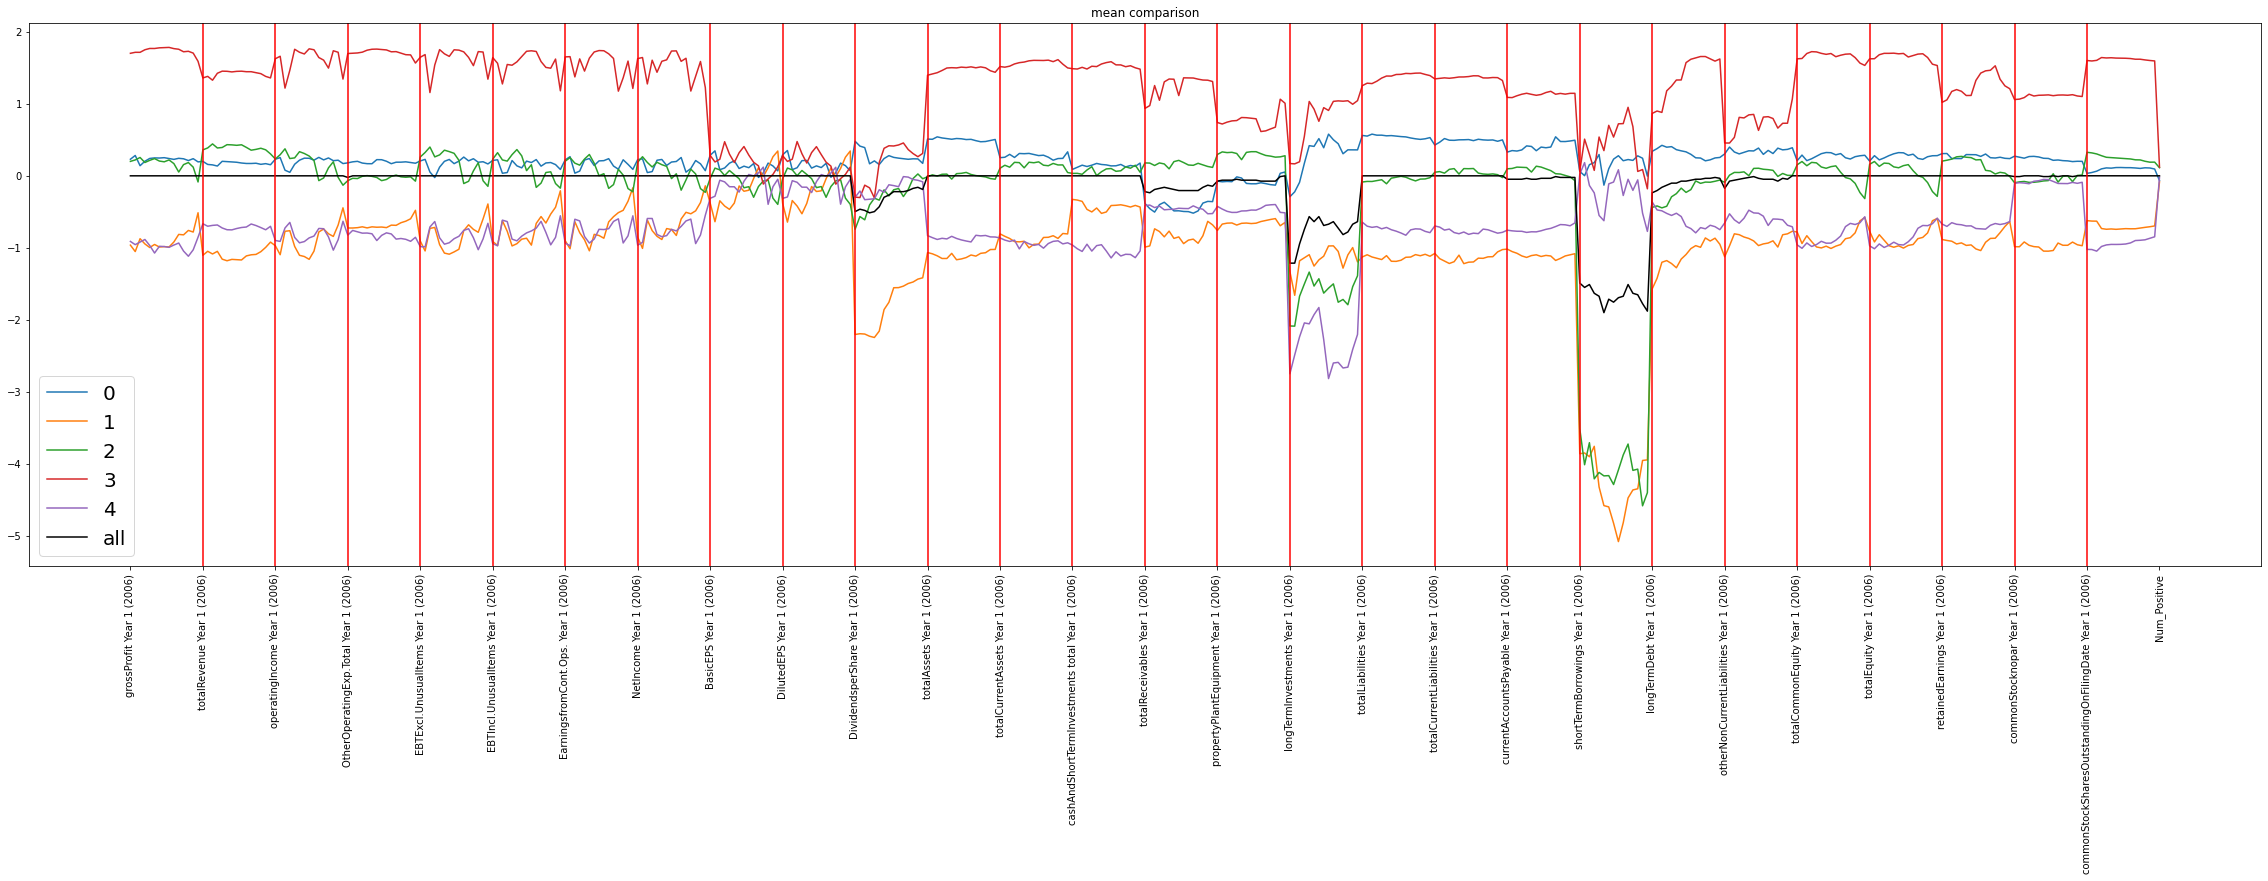

In [32]:
lll = []
for x in range(0,422,15):
    lll.append(x)
list_df = [f0_df,f1_df,f2_df,f3_df,f4_df]

plt.figure(figsize=(40,10))
for x,y in zip(list_df,range(0,5)):
    plt.plot(x.describe().iloc[1], label = '{}'.format(y))
#plt.plot(f1_df.describe().iloc[1],color='g', label = "1")
plt.plot(df_a.describe().iloc[1],color = 'k', label = 'all')
plt.rc('xtick', labelsize=30)
plt.rc('legend',fontsize=20)
plt.xticks(lll,rotation=90)
# plt.axhline(y=0, color='r', linestyle='-')
for xc in range(15,420,15):
    plt.axvline(x=xc,color='r', linestyle='-')
plt.title('mean comparison')
plt.legend()

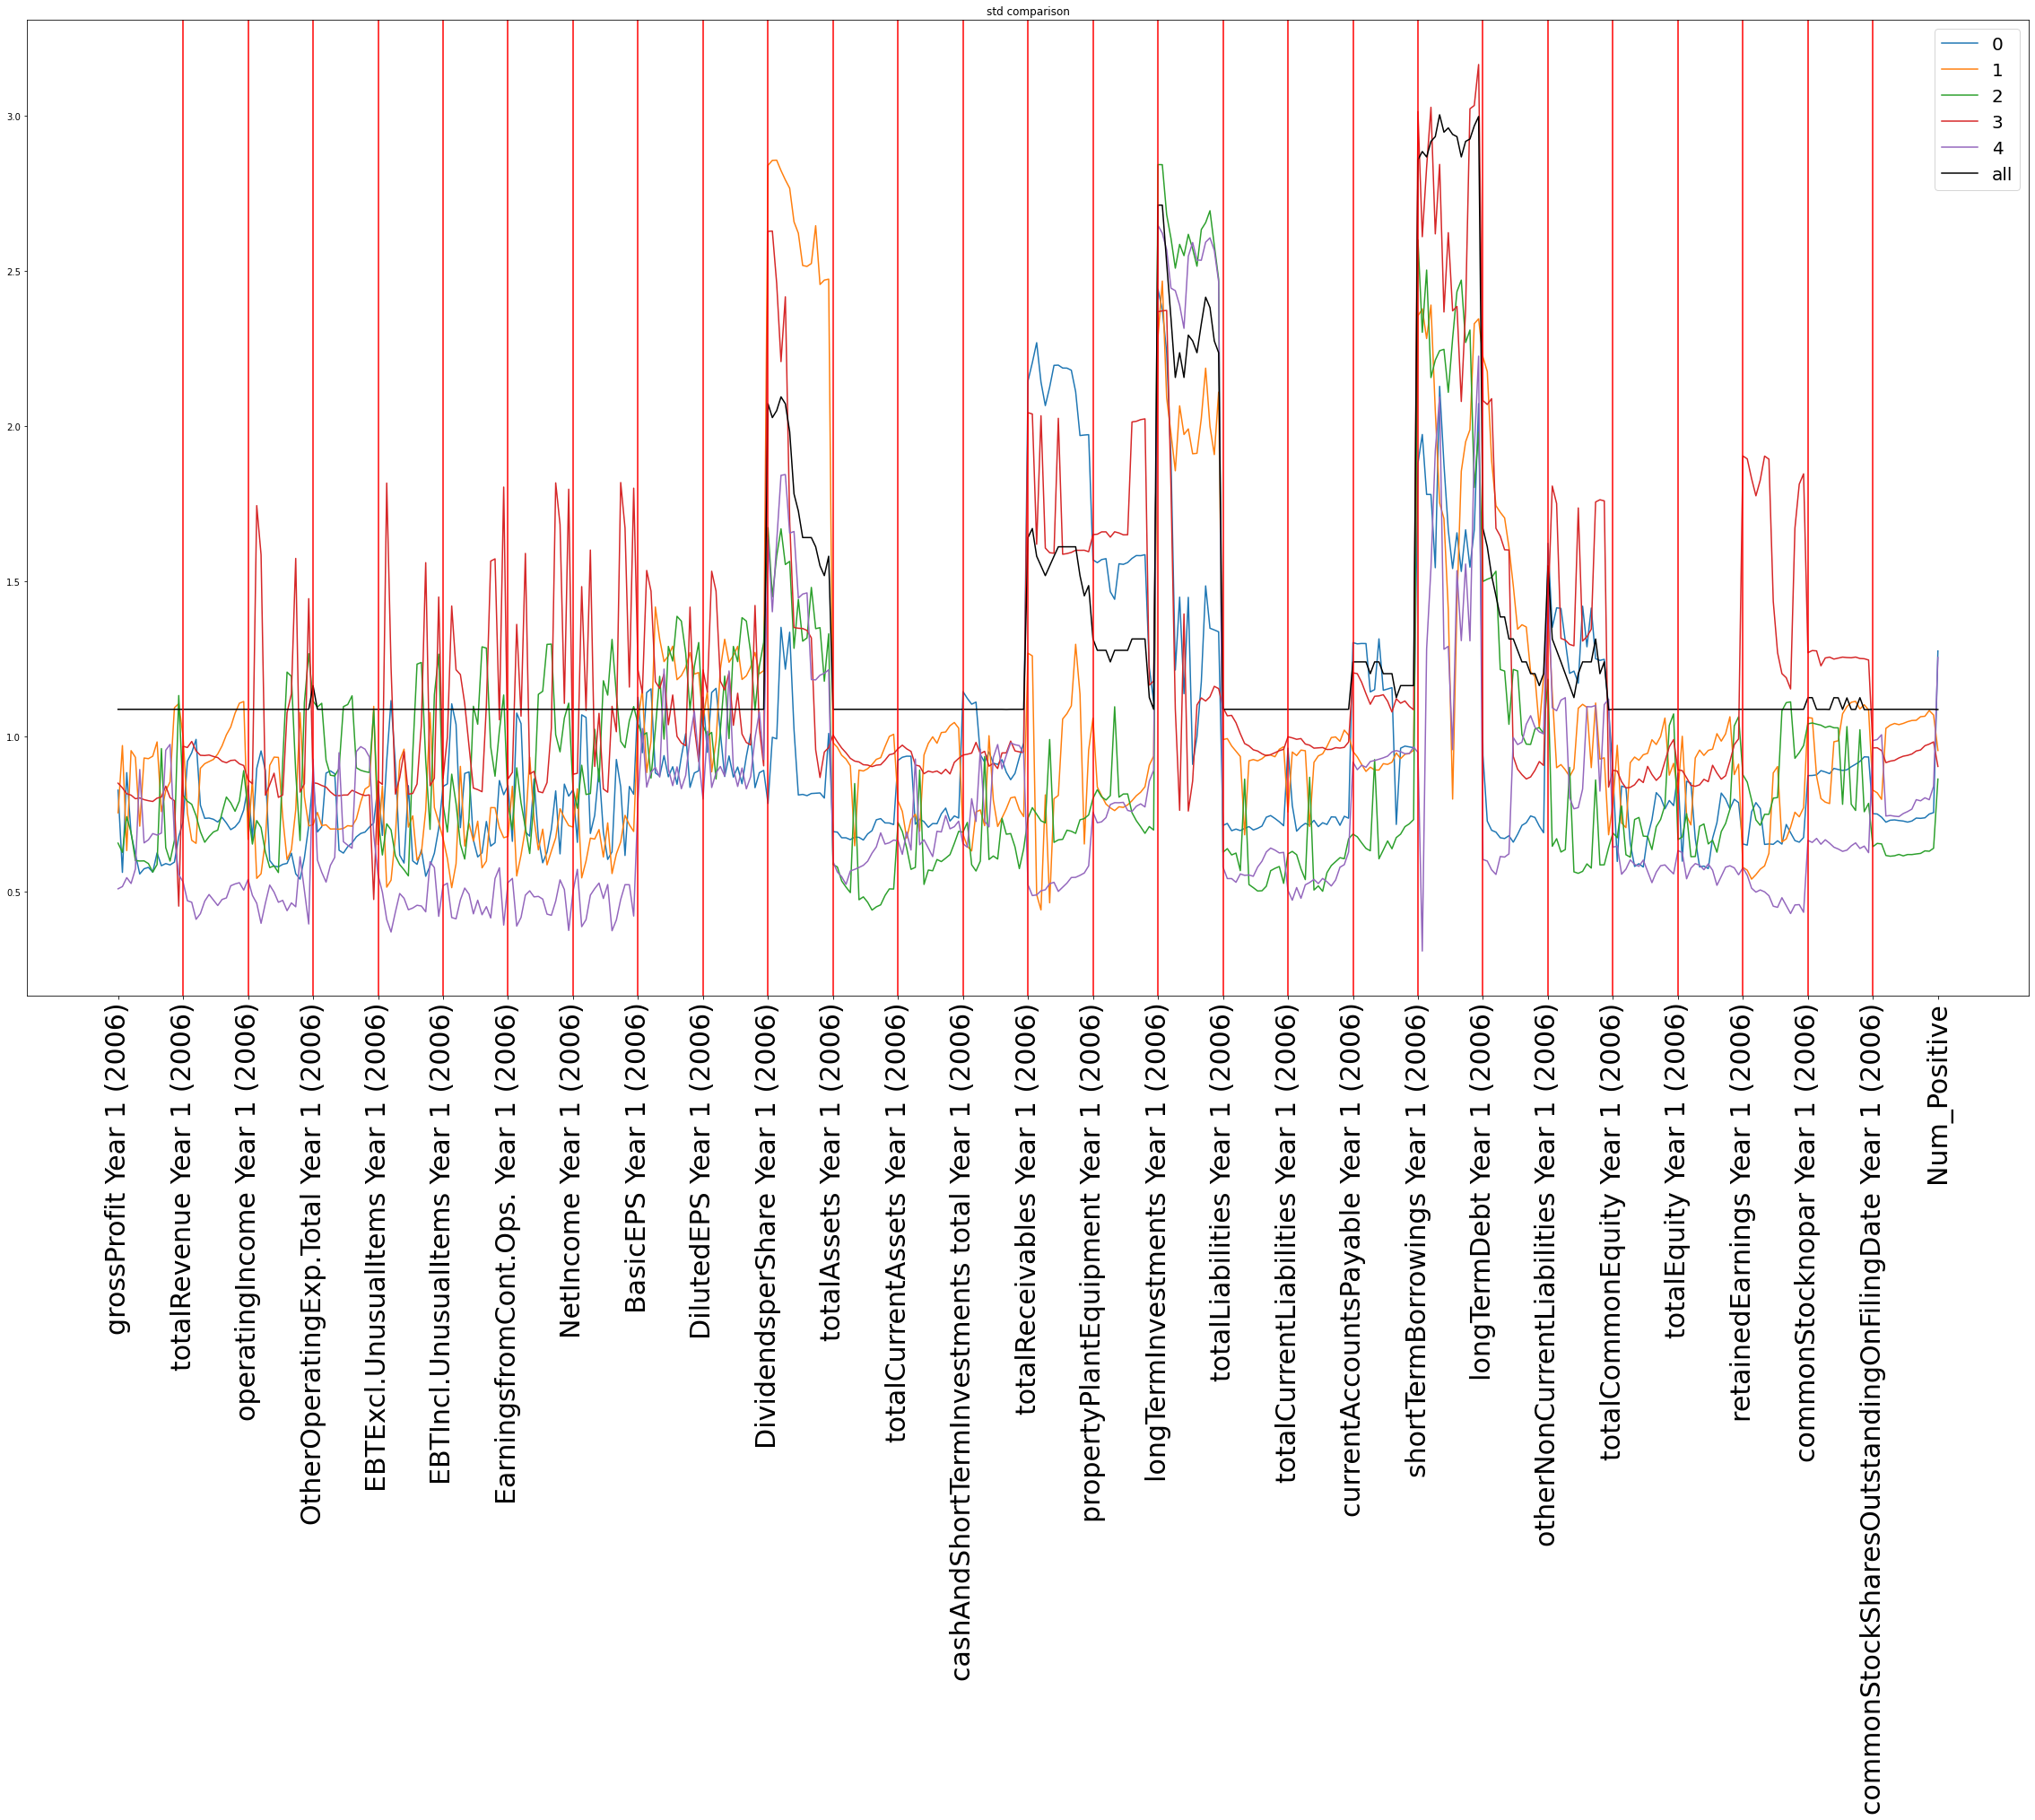

In [33]:
plt.figure(figsize=(40,20))
for x,y in zip(list_df,range(0,5)):
    plt.plot(x.describe().iloc[2], label = '{}'.format(y))
#plt.plot(f1_df.describe().iloc[2],color='g', label = "1")
plt.plot(df_a.describe().iloc[2],color = 'k', label = 'all')
plt.rc('xtick', labelsize=30) 
plt.rc('legend',fontsize=20)
plt.xticks(lll,rotation=90)
# plt.axhline(y=1.087, color='r', linestyle='-')
for xc in range(15,420,15):
    plt.axvline(x=xc,color='r', linestyle='-')
plt.title('std comparison')
plt.legend()

In [34]:
new_list = ['A', 'ADBE', 'ADI', 'ADSK', 'AMD', 'AMZN', 'AZO', 'BBWI', 'BIIB', 'BSX',
       'CTAS', 'CTXS', 'DGX', 'DHI', 'EA', 'EMN', 'EQR', 'FISV', 'IFF', 'INTU',
       'KLAC', 'LEN', 'LH', 'MAR', 'MAS', 'MCO', 'MSI', 'MU', 'NLOK', 'NTAP',
       'NVDA', 'PAYX', 'PKI', 'PLD', 'PSA', 'RHI', 'SPG', 'TPR', 'TROW', 'VMC',
       'VNO', 'WAT', 'YUM', 'ZBH']
old_list =['A', 'ADBE', 'ADI', 'ADSK', 'AMD', 'AMZN', 'AZO', 'BBWI', 'BIIB', 'BSX',
       'CTAS', 'CTXS', 'DGX', 'DHI', 'EA', 'EMN', 'EQR', 'FISV', 'INTU',
       'KLAC', 'LEN', 'LH', 'MAR', 'MAS', 'MCO', 'MSI', 'MU', 'NLOK', 'NTAP',
       'NVDA', 'PAYX', 'PKI', 'PLD', 'PSA', 'RHI', 'SPG', 'TPR', 'TROW', 'VMC',
       'VNO', 'WAT', 'WY', 'YUM', 'ZBH']
for x in old_list:
    if x not in new_list:
        print('deletion:',x)
for x in new_list:
    if x not in old_list:
        print('new addition:',x)

deletion: WY
new addition: IFF
